In [11]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root='./data', train=True, transform=trans, download=True)
test_set = dset.MNIST(root='./data', train=False, transform=trans)
batch_size = 32

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

In [15]:
class AlexNet(nn.Module):
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),

        )

    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [17]:
def train(model, data_loader, loss_fn, optimizer, accuracy_fn, train_losses, train_accuracy, device=device):
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [18]:
def test(data_loader, model, loss_fn, accuracy_fn, test_losses, test_accuracy, device=device):
    model.to(device)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [19]:
model = AlexNet()
print(model)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
device
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train(data_loader=train_loader,
               model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device,
               train_losses=train_losses,
               train_accuracy=train_accuracy
    )
    test(data_loader=test_loader,
              model=model,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device,
              test_losses=test_losses,
              test_accuracy=test_accuracy
    )

AlexNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU(in

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30109 | Train accuracy: 11.14%


 10%|█         | 1/10 [00:22<03:18, 22.11s/it]

Test loss: 2.29935 | Test accuracy: 11.35%

Epoch: 1
---------
Train loss: 1.91913 | Train accuracy: 27.30%


 20%|██        | 2/10 [00:44<02:57, 22.14s/it]

Test loss: 0.35427 | Test accuracy: 88.92%

Epoch: 2
---------
Train loss: 0.23262 | Train accuracy: 92.82%


 30%|███       | 3/10 [01:06<02:34, 22.13s/it]

Test loss: 0.10090 | Test accuracy: 96.77%

Epoch: 3
---------
Train loss: 0.12678 | Train accuracy: 96.05%


 40%|████      | 4/10 [01:28<02:13, 22.18s/it]

Test loss: 0.06866 | Test accuracy: 97.74%

Epoch: 4
---------
Train loss: 0.09505 | Train accuracy: 97.03%


 50%|█████     | 5/10 [01:50<01:50, 22.14s/it]

Test loss: 0.05188 | Test accuracy: 98.13%

Epoch: 5
---------
Train loss: 0.07812 | Train accuracy: 97.50%


 60%|██████    | 6/10 [02:12<01:28, 22.13s/it]

Test loss: 0.04166 | Test accuracy: 98.49%

Epoch: 6
---------
Train loss: 0.06616 | Train accuracy: 97.98%


 70%|███████   | 7/10 [02:34<01:06, 22.12s/it]

Test loss: 0.04082 | Test accuracy: 98.71%

Epoch: 7
---------
Train loss: 0.05870 | Train accuracy: 98.12%


 80%|████████  | 8/10 [02:56<00:44, 22.10s/it]

Test loss: 0.03471 | Test accuracy: 98.84%

Epoch: 8
---------
Train loss: 0.05309 | Train accuracy: 98.30%


 90%|█████████ | 9/10 [03:19<00:22, 22.15s/it]

Test loss: 0.03116 | Test accuracy: 98.99%

Epoch: 9
---------
Train loss: 0.04819 | Train accuracy: 98.46%


100%|██████████| 10/10 [03:41<00:00, 22.15s/it]

Test loss: 0.02994 | Test accuracy: 99.09%



Text(0, 0.5, 'percent')

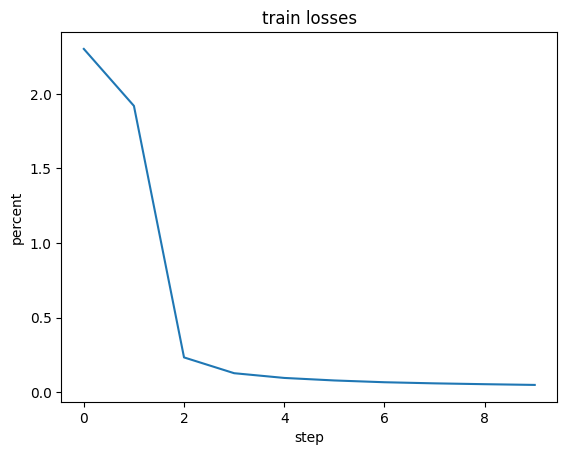

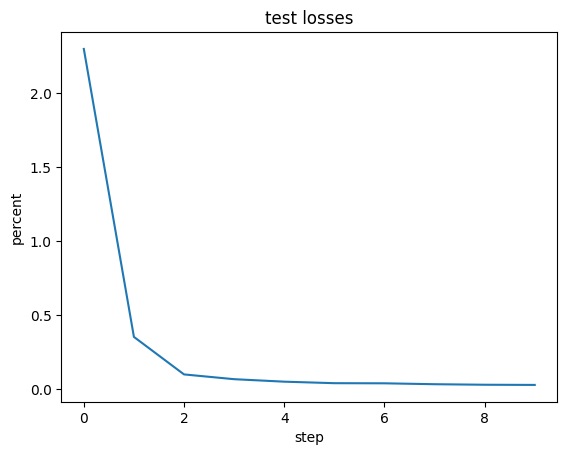

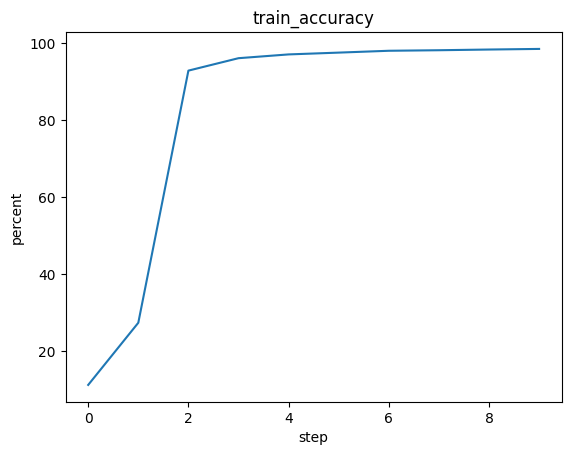

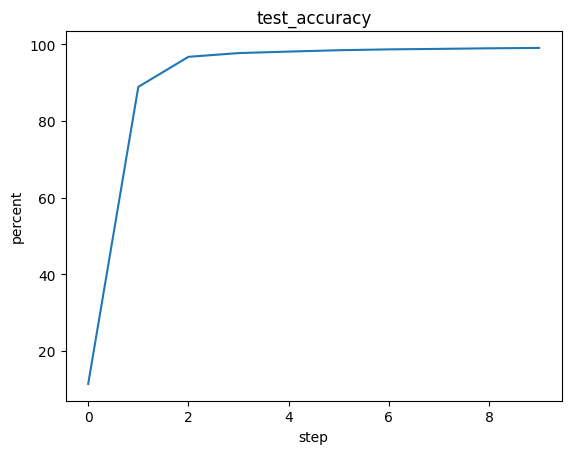

In [20]:
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(train_accuracy)
plt.title('train_accuracy')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('step')
plt.ylabel('percent')